In [113]:
from notebooks.imports import *

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import numpy


In [114]:
print(PreProcess)

<class 'src.features.preprocess.PreProcess'>


In [115]:
#config

subreddit = "music"

In [116]:
# subreddit = "computerscience"
world_posts = pd.read_csv('../data/raw/{}_hot_posts.csv'.format(subreddit))
world_comments = pd.read_csv('../data/raw/{}_hot_comments.csv'.format(subreddit))

# 1. Preprocess

In [117]:
def preprocess(df, col):
    preprocessor = PreProcess()
    preprocessor.fill_na(df, col)
    preprocessor.remove_urls(df, col)
    preprocessor.expand_contractions(df, col)
    preprocessor.remove_escape_chars(df, col)
    return df

### Posts

In [118]:
world_posts.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created
0,skmplg,"Hey there, it’s Amber Mark and I can’t wait to...",16,0.83,Music,https://www.reddit.com/r/Music/comments/skmplg...,61,It’s an honor to be able to speak with you all...,1.644005e+09
1,sk4ysj,Red Hot Chili Peppers announce new album: Unli...,6454,0.95,Music,https://www.reddit.com/r/Music/comments/sk4ysj...,669,Article: https://consequence.net/2022/02/red-h...,1.643951e+09
2,skfwdf,"Fleetwood Mac Released Their Album, Rumours, 4...",812,0.93,Music,https://www.reddit.com/r/Music/comments/skfwdf...,96,https://consequence.net/2022/02/fleetwood-mac-...,1.643988e+09
3,skhz05,Why is it impossible to post anything here?,196,0.88,Music,https://www.reddit.com/r/Music/comments/skhz05...,88,I can't post anything without it getting filte...,1.643993e+09
4,sjsl3q,Spotify CEO addresses Joe Rogan controversy: “...,25370,0.86,Music,https://www.reddit.com/r/Music/comments/sjsl3q...,7895,Article: https://pitchfork.com/news/spotify-ce...,1.643918e+09


In [119]:
posts_df = world_posts.drop(columns=["subreddit", "url","title", "created"])
posts_df.head()

,post_id,score,upvote_ratio,num_comments,body
0,skmplg,16,0.83,61,It’s an honor to be able to speak with you all...
1,sk4ysj,6454,0.95,669,Article: https://consequence.net/2022/02/red-h...
2,skfwdf,812,0.93,96,https://consequence.net/2022/02/fleetwood-mac-...
3,skhz05,196,0.88,88,I can't post anything without it getting filte...
4,sjsl3q,25370,0.86,7895,Article: https://pitchfork.com/news/spotify-ce...


In [120]:
# posts_pre_df = PreProcess.preprocess(posts_df, 'body')
# for i in range(len(posts_df.index)):
#     posts_pre_df.at[i, 'body_string'] = ' '.join([str(elem) for elem in posts_pre_df.at[i, 'body_stem']])
# posts_pre_df.head()

In [121]:
preprocess(posts_df, "body")

,post_id,score,upvote_ratio,num_comments,body
0,skmplg,16,0.83,61,It is an honor to be able to speak with you al...
1,sk4ysj,6454,0.95,669,Article: -hot-chili-peppers-new-album-unlimite...
2,skfwdf,812,0.93,96,"-mac-rumours-anniversary-analysis/Success, of ..."
3,skhz05,196,0.88,88,I cannot post anything without it getting filt...
4,sjsl3q,25370,0.86,7895,Article: -ceo-address-joe-rogan-controversy-we...
...,...,...,...,...,...
352,sizrhf,0,0.50,5,Hi! I have in my mind a music video for my ban...
353,sizlo0,1,1.00,0,I need help finding sheet music or some MIDI d...
354,size7u,1,1.00,0,Imagine a massive art studio which has surroun...
355,siz2d4,0,0.50,5,"So I am obviously a little late to the party, ..."


### Comments

In [122]:
comments_df = world_comments.copy()
comments_df.head()

,post_id,comment,comment_id,parent_id,created,is_submitter
0,skmplg,A lot of artists will really struggle with put...,hvlxbj6,t3_skmplg,1.644007e+09,False
1,skmplg,yes both the label and I initially wanted to p...,hvmamyb,t1_hvlxbj6,1.644012e+09,True
2,skmplg,Amber! I am such a huge huge huge fan! 3:33 ha...,hvm104q,t3_skmplg,1.644008e+09,False
3,skmplg,Thank you so much for listening to my tunes! \...,hvmcq43,t1_hvm104q,1.644012e+09,True
4,skmplg,which song took the longest to make?,hvlvwin,t3_skmplg,1.644006e+09,False


In [123]:
preprocess(comments_df, "comment")

,post_id,comment,comment_id,parent_id,created,is_submitter
0,skmplg,A lot of artists will really struggle with put...,hvlxbj6,t3_skmplg,1.644007e+09,False
1,skmplg,yes both the label and I initially wanted to p...,hvmamyb,t1_hvlxbj6,1.644012e+09,True
2,skmplg,Amber! I am such a huge huge huge fan! 3:33 ha...,hvm104q,t3_skmplg,1.644008e+09,False
3,skmplg,Thank you so much for listening to my tunes! I...,hvmcq43,t1_hvm104q,1.644012e+09,True
4,skmplg,which song took the longest to make?,hvlvwin,t3_skmplg,1.644006e+09,False
...,...,...,...,...,...,...
19710,siz2d4,Shaky Knees fest in Atlanta actually has a pre...,hvbssqk,t1_hvbri1c,1.643836e+09,False
19711,siz2d4,"Absolutely not my bag, but $245 for the When W...",hvdzm86,t3_siz2d4,1.643870e+09,False
19712,siz2d4,"well, most of the OG emo kids are all grown up...",hvh3qg3,t3_siz2d4,1.643924e+09,False
19713,siywv5,Why do not you just download it from the YouTu...,hvbnh8b,t3_siywv5,1.643834e+09,False


# 2. BERT Sentiment Analysis

In [124]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [125]:
def sentiment_score(post):
    tokens = tokenizer.encode(post, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [126]:
posts_df['sentiment'] = posts_df['body'].apply(lambda x: sentiment_score(x[:512]))
posts_df.head()

,post_id,score,upvote_ratio,num_comments,body,sentiment
0,skmplg,16,0.83,61,It is an honor to be able to speak with you al...,5
1,sk4ysj,6454,0.95,669,Article: -hot-chili-peppers-new-album-unlimite...,4
2,skfwdf,812,0.93,96,"-mac-rumours-anniversary-analysis/Success, of ...",5
3,skhz05,196,0.88,88,I cannot post anything without it getting filt...,1
4,sjsl3q,25370,0.86,7895,Article: -ceo-address-joe-rogan-controversy-we...,2


In [100]:
# comments_df['sentiment'] = comments_df['comment'].apply(lambda x: sentiment_score(x[:512]))
# comments_df.head()

,post_id,comment,comment_id,parent_id,created,is_submitter,sentiment
0,skodw7,Get your Body Beat,hvm6vl6,t3_skodw7,1.644010e+09,False,5
1,sknwsn,Beastie Boys have been known to let the beat. ...,hvm1635,t3_sknwsn,1.644008e+09,False,1
2,skmplg,A lot of artists will really struggle with put...,hvlxbj6,t3_skmplg,1.644007e+09,False,3
3,skmplg,what was your favorite location to think about...,hvlvjgg,t3_skmplg,1.644006e+09,False,5
4,skmplg,My favorite location I recorded some of the tr...,hvm3j9u,t1_hvlvjgg,1.644009e+09,True,5


# 3. EDA sentiments of Posts and Comments

In [101]:
posts_df.corr()

,score,upvote_ratio,num_comments,sentiment
score,1.000000,0.074612,0.895129,-0.062179
upvote_ratio,0.074612,1.000000,0.082978,-0.047930
num_comments,0.895129,0.082978,1.000000,-0.068512
sentiment,-0.062179,-0.047930,-0.068512,1.000000


1    102
2     86
3    121
4    391
5    152
Name: sentiment, dtype: int64


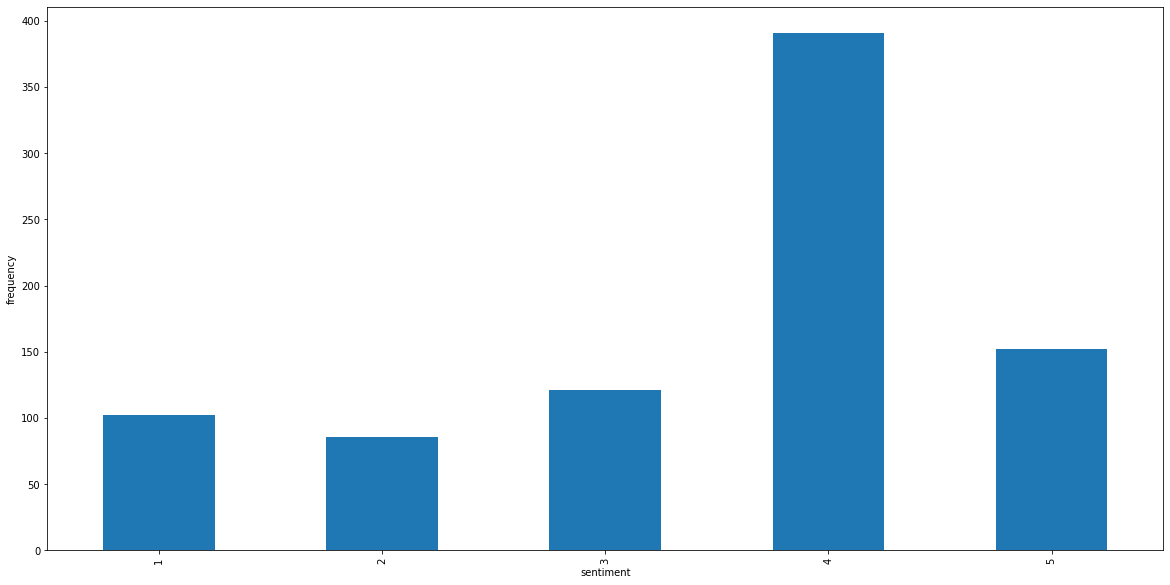

In [102]:
posts_df.sentiment.value_counts().loc[[1, 2, 3, 4, 5]].plot(kind='bar', xlabel='sentiment', ylabel='frequency')
pprint(posts_df.sentiment.value_counts().loc[[1, 2, 3, 4, 5]])
plt.show()

In [103]:
temp_id = posts_df.post_id[0]
print("Looking at one post with id:",temp_id)
posts_df.head(1)

Looking at one post with id: skoinz


,post_id,score,upvote_ratio,num_comments,body,sentiment
0,skoinz,1,1.0,0,,4


In [104]:
median_sentiment_list=[]
for i in posts_df.post_id:
    median_sentiment_list.append(np.median(comments_df[comments_df.post_id==i].sentiment))
posts_df['median_comments_sentiment'] = median_sentiment_list

/Users/saimuktevi/opt/anaconda3/envs/reddit/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/saimuktevi/opt/anaconda3/envs/reddit/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [105]:
posts_df.head()

,post_id,score,upvote_ratio,num_comments,body,sentiment,median_comments_sentiment
0,skoinz,1,1.00,0,,4,NaN
1,skodw7,1,1.00,1,I have my cardio training tomorrow and i want ...,4,5.0
2,sknwsn,1,1.00,1,"For example, there are regular pauses in these...",3,1.0
3,skmplg,5,0.73,24,It is an honor to be able to speak with you al...,5,5.0
4,sknmcq,1,1.00,0,,4,NaN


In [112]:
posts_df

,post_id,score,upvote_ratio,num_comments,body,sentiment,median_comments_sentiment
0,skoinz,1,1.00,0,,4,NaN
1,skodw7,1,1.00,1,I have my cardio training tomorrow and i want ...,4,5.0
2,sknwsn,1,1.00,1,"For example, there are regular pauses in these...",3,1.0
3,skmplg,5,0.73,24,It is an honor to be able to speak with you al...,5,5.0
4,sknmcq,1,1.00,0,,4,NaN
...,...,...,...,...,...,...,...
847,sgigfl,0,0.50,0,,4,NaN
848,sgic2z,2,0.75,18,So with a lot of music groups they have songs ...,3,4.0
849,sgi624,3,1.00,0,,4,NaN
850,sgi2ug,1,1.00,0,,4,NaN


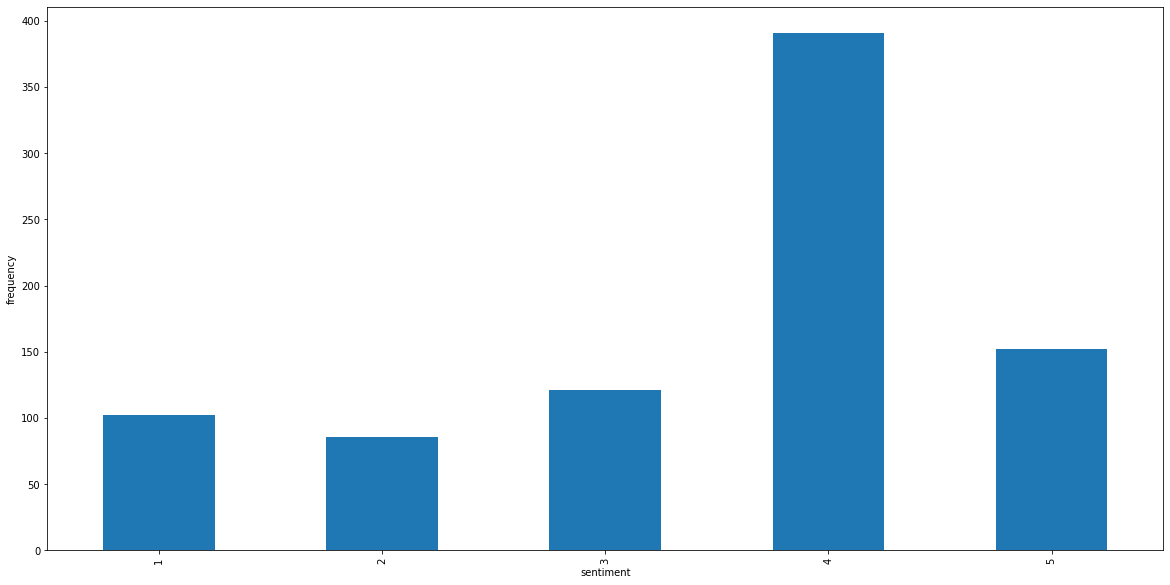

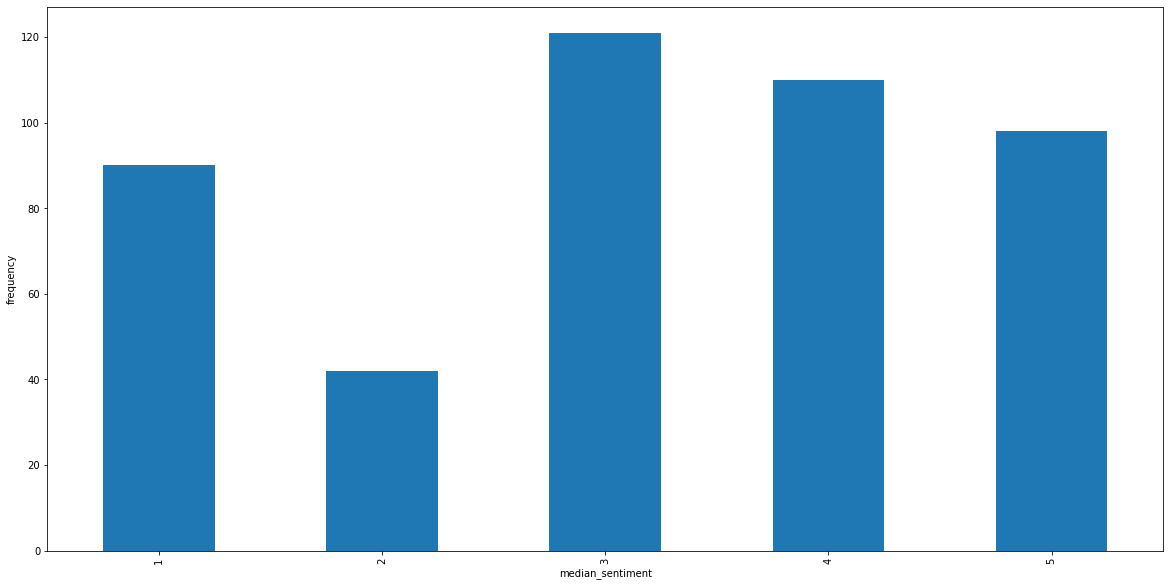

In [106]:
posts_df.sentiment.value_counts().loc[[1, 2, 3, 4, 5]].plot(kind='bar', xlabel='sentiment', ylabel='frequency')
plt.show()
posts_df.median_comments_sentiment.value_counts().loc[[1, 2, 3, 4, 5]].plot(kind='bar', xlabel='median_sentiment', ylabel='frequency')
plt.show()

# 4. Observing with post Metadata

In [107]:
df = posts_df[['post_id','score','upvote_ratio','num_comments', 'sentiment']]
df

,post_id,score,upvote_ratio,num_comments,sentiment
0,skoinz,1,1.00,0,4
1,skodw7,1,1.00,1,4
2,sknwsn,1,1.00,1,3
3,skmplg,5,0.73,24,5
4,sknmcq,1,1.00,0,4
...,...,...,...,...,...
847,sgigfl,0,0.50,0,4
848,sgic2z,2,0.75,18,3
849,sgi624,3,1.00,0,4
850,sgi2ug,1,1.00,0,4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


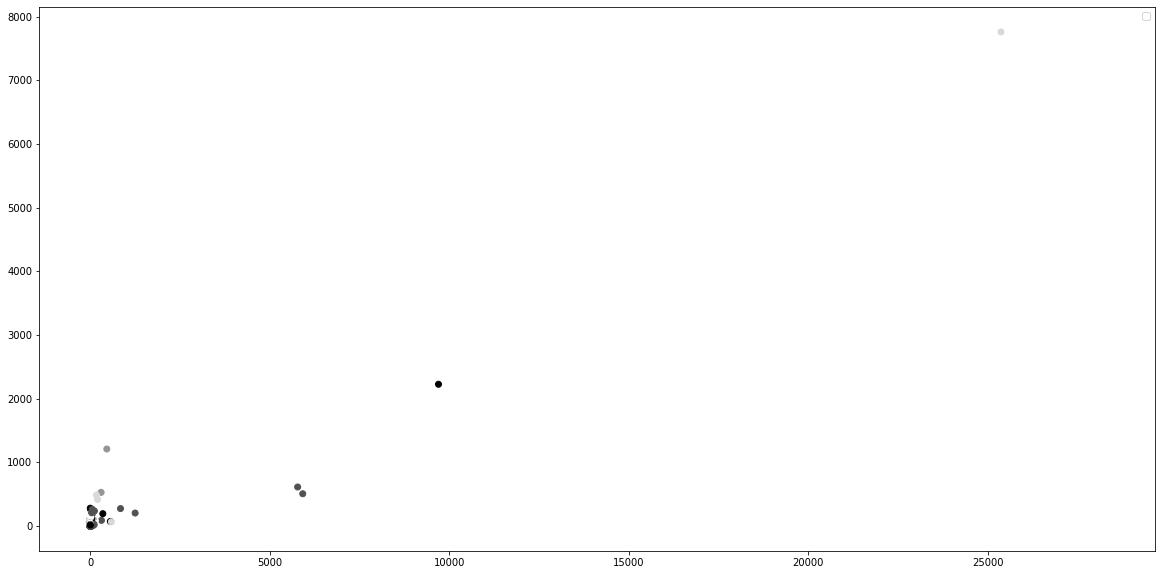

In [108]:
plt.rcParams["figure.figsize"] = (20,10)

plt.scatter(df.score, df.num_comments, c=df.sentiment, cmap="Greys")
plt.legend()
plt.show()

In [109]:
from sklearn.preprocessing import MinMaxScaler
df = posts_df[['post_id','score','upvote_ratio','num_comments', 'sentiment']]
sc = MinMaxScaler()
df = sc.fit_transform(df[['score','upvote_ratio','num_comments']])
df

array([[3.54019896e-05, 1.00000000e+00, 0.00000000e+00],
       [3.54019896e-05, 1.00000000e+00, 1.28816179e-04],
       [3.54019896e-05, 1.00000000e+00, 1.28816179e-04],
       ...,
       [1.06205969e-04, 1.00000000e+00, 0.00000000e+00],
       [3.54019896e-05, 1.00000000e+00, 0.00000000e+00],
       [3.54019896e-04, 9.14893617e-01, 2.18987505e-03]])

In [110]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

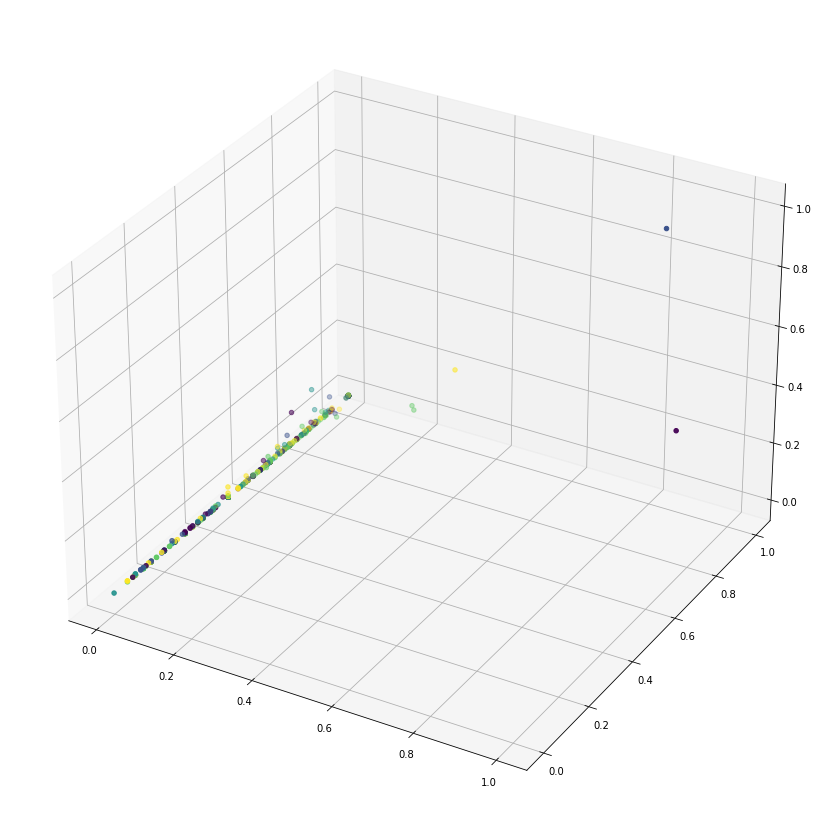

In [111]:
plt.rcParams["figure.figsize"] = (20,15)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df['score'], df['upvote_ratio'], df['num_comments'], c=df['sentiment'])
ax.scatter(df[:, 0], df[:, 1], df[:, 2], c=posts_df.sentiment)
plt.show()

In [53]:
#also try with another subreddit

# 5. Fine-Tuning BERT Sentiment Analysis for our Case